# Fitting V4 voxels from Alexnet conv3 features

In [ ]:
#In this notebook we're going to take an initial stab at fitting the V4 neurons using the alexnet conv3 features

In [180]:
#basic imports
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os


from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RidgeCV, Ridge

In [5]:
# read in the alexnet features
h5f = h5py.File('alexnet/alexnet_conv3_features.h5','r')
train_features = h5f['train'][:] #features for the training images
val_features = h5f['val'][:] #features for the validation images
h5f.close()

In [7]:
train_features.shape

(1750, 14, 14, 384)

In [9]:
# let's bring in the brain data

#read in the mat files
with h5py.File('data/EstimatedResponses.mat','r') as fmri_dataset:
    train_S1 = fmri_dataset['dataTrnS1'][:]
    test_S1 = fmri_dataset['dataValS1'][:]
    roi_S1 = fmri_dataset['roiS1'][:]
    
    train_S2 = fmri_dataset['dataTrnS2'][:]
    test_S2 = fmri_dataset['dataValS2'][:]
    roi_S2 = fmri_dataset['roiS2'][:]
    
    unique_ROIs = np.unique((fmri_dataset['roiS1'])) 

In [17]:
#organize subject 1
S1_train_data_by_ROI = {c: train_S1[:,roi_S1[0,:] == c] 
                       for c in unique_ROIs}
S1_test_data_by_ROI = {c: test_S1[:,roi_S1[0,:] == c] 
                       for c in unique_ROIs}
#organize subject 2
S2_train_data_by_ROI = {c: train_S2[:,roi_S2[0,:] == c] 
                       for c in unique_ROIs}
S2_test_data_by_ROI = {c: test_S2[:,roi_S2[0,:] == c] 
                       for c in unique_ROIs}

In [18]:
S1_train_data_by_ROI.keys()
# remember the one we care about is index 6 for V4

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [20]:
#okay how many voxels are we working with
print(S1_train_data_by_ROI[6.0].shape)
print(S2_train_data_by_ROI[6.0].shape)

(1750, 1550)
(1750, 1022)


In [143]:
#Select only V4 voxels & get rid of any voxels that have NaNs for any training images

#in future versions we may want to replace voxel/image NaNs 
#with the average BOLD response across other images for that voxel
#but got now let's start by just excluding these voxels

#Subject 1
S1_V4 = S1_train_data_by_ROI[6.0].T
x=S1_V4[~np.isnan(S1_V4).any(axis=1)]
S1_V4_train = x.T
print(S1_V4_train.shape)

S1_V4_val = S1_test_data_by_ROI[6.0].T
x=S1_V4_val[~np.isnan(S1_V4).any(axis=1)]
S1_V4_test = x.T
print(S1_V4_test.shape)

sum(sum(np.isnan(S1_V4_test))) #make sure we don't have any NaNs left in the test data

#Subject 2
S2_V4 = S2_train_data_by_ROI[6.0].T
x=S2_V4[~np.isnan(S2_V4).any(axis=1)]
S2_V4_train = x.T
print(S2_V4_train.shape)

S2_V4_val = S2_test_data_by_ROI[6.0].T
x=S2_V4_val[~np.isnan(S2_V4).any(axis=1)]
S2_V4_test = x.T
print(S2_V4_test.shape)

sum(sum(np.isnan(S2_V4_test))) #make sure we don't have any NaNs left in the test data

(1750, 1535)
(120, 1535)
(1750, 1022)
(120, 1022)


0

## Try out regression models with subject 1 data

In [83]:
def rsquared(v1, v2):
    w, b, r, p, ser = stats.linregress(v1, v2)
    return r**2

In [84]:
def evaluate_regression_results(predicted, actual):
    """computing various useful metrics for regression results
    """
    result = {}
    if actual.ndim > 1: #this is triggered if the prediction is of multiple outputs at once
        result['pearson_array'] = np.array([stats.pearsonr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['spearman_array'] = np.array([stats.spearmanr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['rsquared_array'] = np.array([rsquared(p, a) for p, a in zip(predicted.T, actual.T)])
        result['pearson'] = np.median(result['pearson_array'])
        result['spearman'] = np.median(result['spearman_array'])
        result['rsquared'] = np.median(result['rsquared_array'])
    else:
        result['pearson'] = stats.pearsonr(predicted, actual)[0]
        result['spearman'] = stats.spearmanr(predicted, actual)[0]
        result['rsquared'] = rsquared(predicted, actual)
    return result


In [253]:
pls25 = PLSRegression(n_components=50)#, scale=False)

In [254]:
pls25

PLSRegression(copy=True, max_iter=500, n_components=50, scale=True, tol=1e-06)

In [255]:
#flatten the conv features
shp = train_features.shape
train_feats = train_features.reshape((shp[0], np.prod(shp[1:])))
print(train_feats.shape)

shp = val_features.shape
val_feats = val_features.reshape((shp[0], np.prod(shp[1:])))
print(val_feats.shape)

(1750, 75264)
(120, 75264)


In [256]:
pls25.fit(train_feats, S1_V4_train)

PLSRegression(copy=True, max_iter=500, n_components=50, scale=True, tol=1e-06)

In [257]:
S1_pred_train_vox = pls25.predict(train_feats)

In [258]:
train_results = evaluate_regression_results(S1_pred_train_vox,S1_V4_train)

In [259]:
train_results

{'pearson': 0.3920543583208737,
 'pearson_array': array([0.52400149, 0.23512401, 0.19664139, ..., 0.37302986, 0.25043704,
        0.35441066]),
 'rsquared': 0.1537066198783919,
 'rsquared_array': array([0.27457756, 0.0552833 , 0.03866784, ..., 0.13915127, 0.06271871,
        0.12560692]),
 'spearman': 0.369251402671012,
 'spearman_array': array([0.51420718, 0.2243858 , 0.17645073, ..., 0.35844459, 0.24480546,
        0.31393106])}

(array([399., 338., 230., 172., 131.,  99.,  92.,  50.,  14.,  10.]),
 array([0.02509306, 0.08478356, 0.14447406, 0.20416456, 0.26385506,
        0.32354557, 0.38323607, 0.44292657, 0.50261707, 0.56230757,
        0.62199807]),
 <a list of 10 Patch objects>)

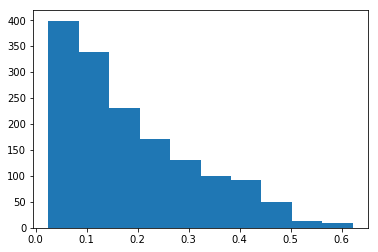

In [261]:
plt.hist(train_results['rsquared_array'])

In [170]:
worst_vox = np.where(train_results['rsquared_array'] == np.amin(train_results['rsquared_array']))
print(worst_vox)
print(train_results['rsquared_array'][worst_vox])

best_vox = np.where(train_results['rsquared_array'] == np.amax(train_results['rsquared_array']))
print(best_vox)

(array([189]),)
[0.02509306]
(array([1397]),)


Text(0.5,1,'Predicted vs. actual response to images \nrval=0.622')

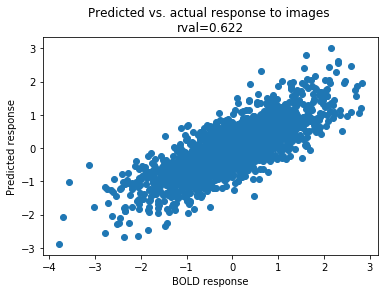

In [171]:
plt.scatter(S1_V4_train[:,best_vox],S1_pred_train_vox[:,best_vox])
plt.xlabel('BOLD response')
plt.ylabel('Predicted response')
plt.title('Predicted vs. actual response to images for the best voxel \nrval=%.3f'% train_results['rsquared_array'][best_vox])

Text(0.5,1,'Predicted vs. actual response to images for the worst voxel \nrval=0.025')

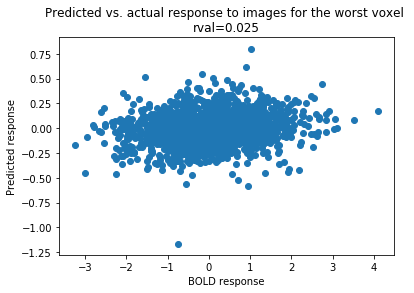

In [172]:
plt.scatter(S1_V4_train[:,worst_vox],S1_pred_train_vox[:,worst_vox])
plt.xlabel('BOLD response')
plt.ylabel('Predicted response')
plt.title('Predicted vs. actual response to images for the worst voxel \nrval=%.3f'% train_results['rsquared_array'][worst_vox])

In [148]:
S1_pred_train_vox.shape

(1750, 1535)

In [282]:
#let's try using ridge regression to fit individual voxels
#(cross-validate regularization params using RidgeCV)
vox_to_check = 500
rs = np.zeros(vox_to_check)
pred_val = np.zeros([120,vox_to_check])
train_val = np.zeros([1750,vox_to_check])
for vox in range(vox_to_check):
    clf = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1])
    clf.fit(train_feats, S1_V4_train[:,vox]) 
    
    train_val[:,vox] = clf.predict(train_feats)
    pred_val[:,vox] = clf.predict(val_feats)
    results = evaluate_regression_results(pred_val[:,vox],S1_V4_test[:,vox])
    
    rs[vox] = results['rsquared']

(array([396.,  41.,  29.,  13.,  10.,   2.,   3.,   3.,   1.,   2.]),
 array([8.61667936e-08, 2.37454267e-02, 4.74907672e-02, 7.12361077e-02,
        9.49814481e-02, 1.18726789e-01, 1.42472129e-01, 1.66217470e-01,
        1.89962810e-01, 2.13708151e-01, 2.37453491e-01]),
 <a list of 10 Patch objects>)

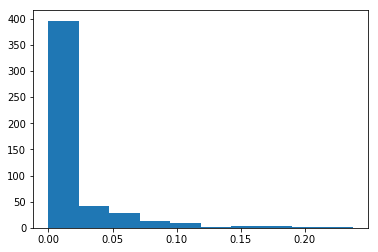

In [283]:
#okay what have we got
plt.hist(rs)

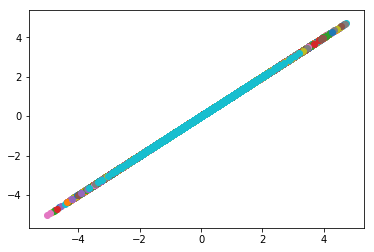

In [302]:
#how does it look for the training predictions
for vox in range(vox_to_check):
    plt.scatter(S1_V4_train[:,vox],train_val[:,vox])
    #hm okay guess we can get a perfect linear mapping for each vox cuz we have so many features?
    #overfitting...

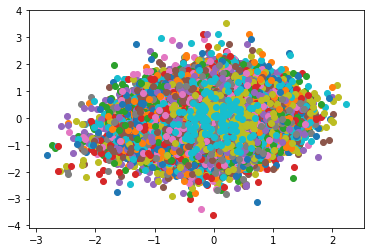

In [284]:
for vox in range(vox_to_check):
    plt.scatter(S1_V4_test[:,vox],pred_val[:,vox])

In [287]:
worst_vox = np.where(rs == np.amin(rs))
print(rs[worst_vox])

best_vox = np.where(rs == np.amax(rs))
print(rs[best_vox])

[8.61667936e-08]
[0.23745349]


Text(0.5,1,'Predicted vs. actual response to images \n Best voxel: rval=0.237')

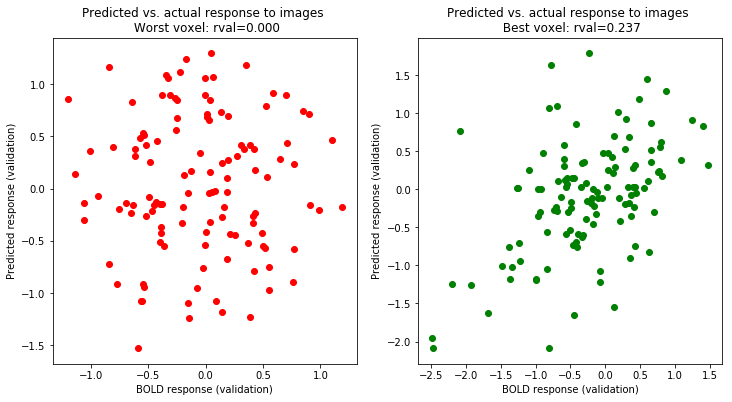

In [301]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(S1_V4_test[:,worst_vox],pred_val[:,worst_vox], c='r')
plt.xlabel('BOLD response (validation)')
plt.ylabel('Predicted response (validation)')
plt.title('Predicted vs. actual response to images \n Worst voxel: rval=%.3f'% rs[worst_vox])
plt.subplot(1, 2, 2)
plt.scatter(S1_V4_test[:,best_vox],pred_val[:,best_vox], c='g')
plt.xlabel('BOLD response (validation)')
plt.ylabel('Predicted response (validation)')
plt.title('Predicted vs. actual response to images \n Best voxel: rval=%.3f'% rs[best_vox])

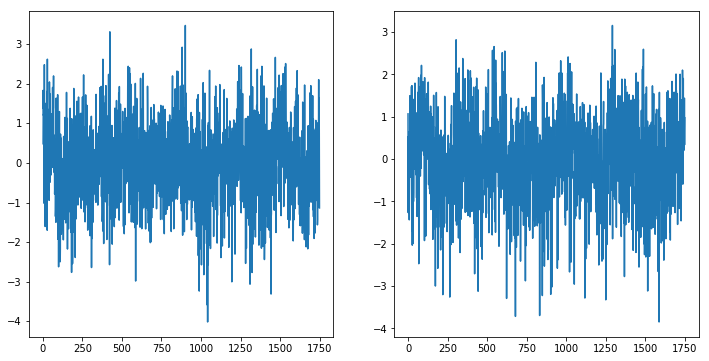

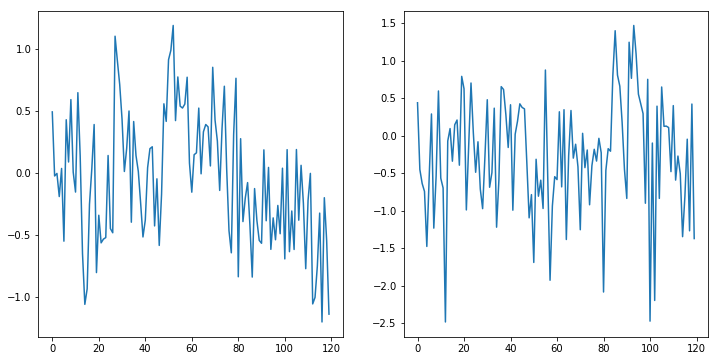

In [309]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(S1_V4_train[:,worst_vox[0]])
plt.subplot(1, 2, 2)
plt.plot(S1_V4_train[:,best_vox[0]])

fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(S1_V4_test[:,worst_vox[0]])
plt.subplot(1, 2, 2)
plt.plot(S1_V4_test[:,best_vox[0]])

## Try out regression models with proper train and test splits

In [356]:
## Alright this has not gone well
# let's start again with proper train and test splits within our training set
# (ignoring the validation data for now)

# first let's load some useful util funcs from yamins lab
from utils import featurewise_norm

In [343]:
# create our own train test splits 
total_imgs = 1750
num_splits = 5
num_per_class_test=250
num_per_class_train=1500

#seed the random number generator
rng = np.random.RandomState(seed=0)

In [344]:
#construct the splits one by one
splits = []
for _split_ind in range(num_splits):
    
    #first construct the testing data
    actual_test_inds = []
    
    perm = rng.permutation(total_imgs)
    actual_test_inds = perm[ :num_per_class_test]
    
    actual_test_inds = np.sort(actual_test_inds)
    
    # then training
    remaining_available_train_inds = np.unique(list(set(
                       perm).difference(actual_test_inds)))
    actual_train_inds = np.sort(remaining_available_train_inds)

    split = {'train': actual_train_inds, 'test': actual_test_inds}
    splits.append(split)

In [347]:
def aggregate_regression_results(results_by_split):
    """convenience function aggregating results of regression tests over data splits
    """
    results = {}
    results['by_split'] = results_by_split
    ns = len(results_by_split)
    for k in results_by_split[0]:
        arr = np.array([results_by_split[i][k] for i in range(ns)])
        if arr.ndim == 1:
            results['mean_' + k] = arr.mean()
            results['std_' + k] = arr.std()
        else:
            results['mean_' + k] = arr.mean(axis=0)
            results['std_' + k] = arr.std(axis=0)
    return results

In [433]:
def train_and_test_scikit_regressor(features, 
                                    labels,
                                    splits,
                                    model_class,
                                    model_args=None,
                                    gridcv_params=None,
                                    gridcv_args=None,
                                    fit_args=None,
                                    feature_norm=True,
                                    return_models=False
                                    ):
    """This function is very similar to the train_and_test_scikit_classifier function
       except it is adapted for working with regressors.
    """

    if model_args is None:
        model_args = {}
    if fit_args is None:
        fit_args = {}
    
    training_sidedata = []
   
    models = []
    train_results = []
    test_results = []
    
    total_train_preds = []
    total_test_preds = []
    
    for split in splits:

        #here we instantiate the general regressor whatever it is
        model = model_class(**model_args)
        if gridcv_params is not None:
            if gridcv_args is None:
                gridcv_args = {}
            model = GridSearchCV(model, gridcv_params, **gridcv_args)
            
        #get the train/test split data
        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        #train the model ...
        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        model.fit(train_features, train_labels, **fit_args)
        
        #... and get training predictions and results
        train_predictions = model.predict(train_features)
        train_result = evaluate_regression_results(train_predictions, train_labels)
        train_results.append(train_result)
             
        #test the model ... 
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
        #... and get testing predictions and results
        test_predictions = model.predict(test_features)
        test_result = evaluate_regression_results(test_predictions, test_labels)
        test_results.append(test_result)
        
        total_train_preds.append(train_predictions)
        total_test_preds.append(test_predictions)
        
        if return_models:
            models.append(model)
        
    #aggregate results over splits
    train_results = aggregate_regression_results(train_results)
    test_results = aggregate_regression_results(test_results)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results, total_train_preds, total_test_preds

In [434]:
resPLS = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False},
                                feature_norm=False)

In [439]:
print(resPLS[0]['train']['mean_rsquared']) 
print(resPLS[0]['test']['mean_rsquared']) #yikes we are not doing well

0.08577699208674307
0.0032967460812370506


In [457]:
resPLS

({'test': {'by_split': [{'pearson': 0.028729012868035374,
     'pearson_array': array([ 0.224926  , -0.0286369 , -0.01761476, ...,  0.0098386 ,
            -0.10782828,  0.03769258]),
     'rsquared': 0.003294609623544939,
     'rsquared_array': array([5.05917074e-02, 8.20072060e-04, 3.10279828e-04, ...,
            9.67980631e-05, 1.16269370e-02, 1.42073059e-03]),
     'spearman': 0.028144962319397112,
     'spearman_array': array([ 0.21606298, -0.00022848, -0.01380848, ...,  0.01598886,
            -0.08556924,  0.05766044])},
    {'pearson': 0.03353661801424711,
     'pearson_array': array([ 0.28271821,  0.10238805, -0.00520658, ...,  0.01815725,
            -0.0179482 , -0.09236   ]),
     'rsquared': 0.0032083897144271354,
     'rsquared_array': array([7.99295872e-02, 1.04833124e-02, 2.71084260e-05, ...,
            3.29685889e-04, 3.22138054e-04, 8.53036919e-03]),
     'spearman': 0.033925790812653,
     'spearman_array': array([ 0.27110258,  0.13890693, -0.00352786, ..., -0.0073

In [363]:
resRidgeCV = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]},
                                feature_norm=False)

In [365]:
print(resRidgeCV['train']['mean_rsquared']) 
print(resRidgeCV['test']['mean_rsquared']) 

0.9999999984553636


In [358]:
resPLS_fnorm = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False},
                                feature_norm=True)

In [360]:
resPLS_fnorm['test']['mean_rsquared'] #okay didn't help to feature norm...

0.0029567305104798106

In [479]:
## let's subsample the features - should speed things up/maybe help with overfitting?
n = train_feats.shape[1]  
perm = rng.permutation(n)
#let's just keep 10000
keep_inds = perm[: 10000]
train_feats_sub = train_feats[:, keep_inds]
val_feats_sub = val_feats[:, keep_inds]

In [368]:
train_feats_sub.shape

(1750, 5000)

In [371]:
#okay gonna try Ridge again (that seemed to overfit like crazy the first time...)
resRidge_sub = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]}, 
                                feature_norm=False)

In [373]:
print(resRidge_sub['train']['mean_rsquared'])
print(resRidge_sub['test']['mean_rsquared']) #that still overfit training and failed test! ugh

0.9999967395887044
0.0022067092131015913


In [374]:
resPLS_sub = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 50,
                                            'scale': False},
                                feature_norm=False)

In [375]:
resPLS_sub['test']['mean_rsquared'] #well it didn't hurt

0.002814257771610069

In [474]:
#maybe I can use this to speed up fitting individual voxels with ridge

vox_to_check = 1535 #let's check them all
rs = np.zeros(vox_to_check)
test_rsquared=np.zeros([vox_to_check,1])
train_pred = np.zeros([vox_to_check,1500])
test_pred = np.zeros([vox_to_check,250])

#lil_split = splits[0], #let's just use one of the splits
for vox in range(vox_to_check): 
    vox_res, vox_train_pred, vox_test_pred = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train[:,vox],
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]}, 
                                feature_norm=False)
    
    test_rsquared[vox,:]=vox_res['test']['mean_rsquared']
    #train_pred[vox,:] = vox_train_pred[0]
    #test_pred[vox,:] = vox_test_pred[0]

KeyboardInterrupt: 

In [ ]:
plt.hist(test_rsquared)

In [466]:
#is this consistently the same voxels that are fit well?
best_vox_inds = np.where(test_rsquared > .01)

In [467]:
best_vox_inds[0].shape

(5,)

In [470]:
vox = best_vox_inds[0][idx]
vox

10

In [476]:
#check validation but only for these A+ voxels

vox_to_check = 5

best_rs = np.zeros(vox_to_check)
best_pred_val = np.zeros([120,vox_to_check])
best_train_val = np.zeros([1750,vox_to_check])

for idx in range(vox_to_check): 
    
    vox = best_vox_inds[0][idx]
    
    clf = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1])
    clf.fit(train_feats_sub, S1_V4_train[:,vox]) 
    
    best_train_val[:,idx] = clf.predict(train_feats_sub)
    best_pred_val[:,idx] = clf.predict(val_feats_sub)
    results = evaluate_regression_results(best_pred_val[:,idx],S1_V4_test[:,vox])
    
    best_rs[idx] = results['rsquared']
    

(array([1., 2., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.00027004, 0.00660113, 0.01293222, 0.01926331, 0.0255944 ,
        0.03192549, 0.03825658, 0.04458767, 0.05091877, 0.05724986,
        0.06358095]),
 <a list of 10 Patch objects>)

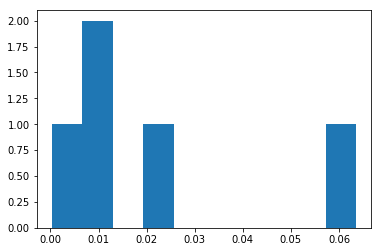

In [477]:
plt.hist(best_rs)